# XL741/741SE simulation and experiments

By Shuo Chen (chenshuo_at_chenshuo.com) [30% done]

Latest notebook: https://github.com/chenshuo/notes/blob/master/notebooks/XL741.ipynb

Comments and discussions: https://github.com/chenshuo/notes/discussions

In [11]:
%matplotlib inline

from math import exp, log, log10

# NgSpice
import ngspyce as ng

import numpy as np
from matplotlib import pyplot as plt
import scipy

def para(r1, r2):
    return (r1*r2) / (r1 + r2)

def print_op(print_base_current=True, print_emitter_current=False):
  op = ng.operating_point()
  for k in sorted(op.keys()):
    if k[0] == '@' or '#branch' in k:
        if '[is]' in k:
            continue
        if '[ib]' in k and not print_base_current:
            continue
        if '[ie]' in k and not print_emitter_current:
            continue

        print('%10s = %8.2f uA' % (k, 1e6*op[k][0]))
    else:
        print('%10s = %8.2f mV' % (k, 1e3*op[k][0]))

In [2]:
# Circuitikz
# pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

%load_ext tikzmagic

[XL741](https://shop.evilmadscientist.com/productsmenu/762) and [741SE](https://shop.evilmadscientist.com/productsmenu/923) are
faithful and functional transistor-scale replicas of the μA741 op-amp integrated circuit, designed by [Eric Schlaepfer](http://tubetime.us/), in collaboration with [Evil Mad Scientist Laboratories](https://www.evilmadscientist.com/). Here's [the central documentation site](https://wiki.evilmadscientist.com/741) for these discrete 741 Op-Amp kits.

## Schematic

**A bit of datasheet archaeology**

AFAIK, there are three common variants of µA741:

* Fairchild's original 20-transistor µA741/µA741C, as seen in [1970 datasheet](fairchild1970.pdf). 
* Fairchild's improved 24-transistor µA741A/µA741E, first seen in  [1973 datasheet](fairchild1973a.pdf), interestingly, the [1973 databook](fairchild1973.pdf) also lists µA741/µA741C, right before µA741A datasheets.
Years later, in [1979 databook](fairchild1979.pdf), only 24-transistor '741 survived and named just 'µA741'.
* TI's 22-transistor [uA741](ti1984.pdf), but the datasheet doesn't label the transistors or resistor values.

> Databooks are taken from <http://www.bitsavers.org/components/fairchild/_dataBooks/>

My wild guess: Fairchild improved their fabrication in 1972/1973, and tweeked original µA741 to make µA741A.

One evidence: the typical input bias current (average base currents of Q1/Q2) reduced from 80nA to 30nA, if the collector currents of Q1/Q2 kept the same (around 9.5µA per transistor per calculation below), we could infer that the $\beta$ of NPN transistors improved from $9.5 / 0.08 \approx 120$ to $9.5 / 0.03 \approx 310$.

The XL741/741SE kits employ the original 20-transistor schematic, probably because the double collector PNP transistor Q13 in the 24-transistor design is not avaivable as discrete componments.

Here's the schematic of XL741/741SE, with simulated DC operating points.

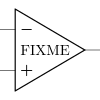

In [9]:
%%tikz -p circuitikz -s 100,100 -f svg
\draw (0, 0) node [op amp] (OA1) {FIXME};
% # FIXME: full schematic here

[741: Principles of Operation](https://cdn.evilmadscientist.com/KitInstrux/741/741_principles_Rev21.pdf) explains this circuit in great details. A few notes based on simulation results:

* Systematic error of input offset voltage ~0.5mV, even with perfectly matched transistors.
* 


## Analysis and Simulation

The analysis and calculation in this section closely follows
Chapter 12 of _Sedra & Smith 6e_, which I keep on my desktop.
The same content is now available for download from
[Supplement x4](https://learninglink.oup.com/access/sedra8e-student-resources#tag_bonus-text-topics) of [_Microelectronic Circuits 8e_](https://learninglink.oup.com/access/sedra8e)

The simulation ideas were from [Chapter 10](https://www.ece.mcgill.ca/~grober4/SPICE/SPICE_Decks/1st_Edition/chapter10/Chapter%2010%20%20Analog%20Integrated%20Circuits%20web%20version.html) of [_SPICE for Microelectronic Circuits_](https://www.ece.mcgill.ca/~grober4/SPICE/SPICE_Decks/spicedecks_ed1_index.html) by Gordon W. Roberts and Adel S. Sedra. I have possession of a physical copy of the second edition.

It's worth note that these two books analyze the 24-transistor variant of 741, while XL741/741SE are the 20-transistor variant. According to Ken Shirriff in [Understanding silicon circuits: inside the ubiquitous 741 op amp](https://www.righto.com/2015/10/inside-ubiquitous-741-op-amp-circuits.html#ref11), the 24-transistor variant is more common.

### Transistor parameters

XL741 is built with discrete 2N3904 (NPN) and 2N3906 (PNP) transistors, although their SPICE models can be found from manufacturer's datasheets, 
Dr. Kent H. Lundberg says these models are "worthless" and suggests not to use them in simulations. <https://www.mit.edu/~6.301/>. I agree with him, because the model parameters disagree with my measurement. In particular, while the Vaf of PNP is only 18.7V, which is too low to be true. Another source https://physics.uncg.edu/hellen/spice_stuff.html
$\newcommand{\uv}[1]{{V_\mathrm{#1}}} \newcommand{\Vt}{\uv{T}}  \newcommand{\Vbe}{\uv{BE}}$
$\newcommand{\ui}[1]{{I_\mathrm{#1}}} \newcommand{\Is}{\ui{S}}$
$\newcommand{\mV}{\mathrm{mV}} \newcommand{\mA}{\mathrm{mA}} \newcommand{\uA}{\mathrm{µA}}$

**Measure**

TBD

I measured 3 2N3904 and 3 2N3906 (TO-92 packages, not SOT-23 come with my 741SE kits) using multimeters and a cheap [AVR transistor tester](https://www.mikrocontroller.net/articles/AVR_Transistortester) clone from Ebay, here's the results:

FIXME:

Recall basic Ebers-Moll model:

$\ui{E} = \Is\exp\dfrac{\uv{BE}}{\Vt}$

$\uv{BE}=\Vt\ln\dfrac{\ui{E}}{\Is}$

We assume $\Vt=25.8\mathrm{mV}$

**Parameters for calculation and simulation**

| Transistor | $\beta$ | $\Is$ | Early voltage $\uv{A}$* |
| --- | --- | --- | --- |
| NPN (2N3904) | | 10fA | |
| PNP (2N3906) | | 10fA | |

Given $\beta\gg 1$, we are going to ignore base currents in calculation below unless otherwise mentioned.

\* I didn't measure the Early voltage, but just use the value from Sedra&Smith book.
It doesn't affect the calculation of DC operating points, but does affect the DC gain simulation.

### Bias

The bias circuit (redraw below) consists of Q10/Q11/Q12/Q13.



The current on $R_5$ is the reference current, and it's set by power supply voltage, $\uv{CC}=15$V, $\uv{EE}=-15$V.
Assuming $\uv{BE} = 0.65$V for Q11 and Q12.

$\ui{REF}=\ui{R5}=\dfrac{\uv{CC}-\uv{EE}-2\times\uv{BE}}{R_5} = \dfrac{30-2\times 0.65}{39\mathrm{k}} = 0.736\mA$

Q10/Q11 and R4 form a Wildar current source.

$I_\mathrm{C10} R_4 = V_\mathrm{T}\ln \dfrac{I_\mathrm{REF}}{I_\mathrm{C10}}$

It's a transcendental equation, let's solve $\ui{C10}$ using numerical method, which gives 19.84µA.

In [12]:
def Ic10(x):
    Ic = x
    Vt = 25.8
    Iref = 736
    R4 = 4.7
    return Ic * R4 - Vt * np.log(Iref / Ic)

# Trial and error
if False:
    print(Ic10(10))
    print(Ic10(20))
    print(Ic10(19))
    print(Ic10(19.5))
    print(Ic10(19.8))

root = scipy.optimize.root_scalar(Ic10, x0=0.1)
if root.converged:
    Ic = root.root
    print('Ic10 = %.2f uA' % (Ic))

Ic10 = 19.84 uA


### Input stage

Given $\beta \gg 1$, ignoring base currents and assuming $\ui{E}\approx\ui{C}$.
Due to the current mirror made of Q5/Q6, we shall have $\ui{C1} = \ui{C2} = \ui{C3} = \ui{C4} = \ui{C5} = \ui{C6}$

The input stage bias can be viewed as a Wilson current source (shown below, Q1/Q2/D1/D2 are considered as short-circuit wires), the input (reference) current is $\ui{C10}$, the output current is $\ui{C8} = \ui{C1} + \ui{C2}$. Clearly $\ui{C1} = \ui{C2} = \dfrac{\ui{C10}}{2} = 9.9\uA$

### Gain stage

Q16 and Q17 form a Darlinton pair, which provides most (if not all) of voltage gain.

### Output stage

## Measure with multimeter

TBC